In [1]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.distributions import Categorical

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')

# ---
frame_size = 10
batch_size = 10
n_epochs   = 100
plot_every = 30
step       = 0
num_items    = 5000 # n items to recommend. Can be adjusted for your vram 
# --- 
tqdm.pandas()


from jupyterthemes import jtplot
jtplot.style(theme='grade3')

In [2]:
def embed_batch(batch, item_embeddings_tensor, *args, **kwargs):
    return recnn.data.batch_contstate_discaction(batch, item_embeddings_tensor,
                                                 frame_size=frame_size, num_items=num_items)

    
def prepare_dataset(**kwargs):
    recnn.data.build_data_pipeline([recnn.data.truncate_dataset,
                                    recnn.data.prepare_dataset], reduce_items_to=1000, **kwargs)
    
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
env = recnn.data.env.FrameEnv('../../data/embeddings/ml20_pca128.pkl',
                              '../../data/ml-20m/ratings.csv', frame_size, batch_size,
                              embed_batch=embed_batch, prepare_dataset=prepare_dataset,
                              num_workers = 0)

action space is reduced to 26744 - 25744 = 1000


In [3]:
value_net  = recnn.nn.Critic(1290, num_items, 2048, 54e-2).to(cuda)
value_net.save_limit = 15
policy_net = recnn.nn.DiscreteActor(1290, num_items, 2048).to(cuda)

reinforce = recnn.nn.Reinforce(policy_net, value_net)
reinforce = reinforce.to(cuda)

plotter = recnn.utils.Plotter(reinforce.loss_layout, [['value', 'policy']],)

step 990


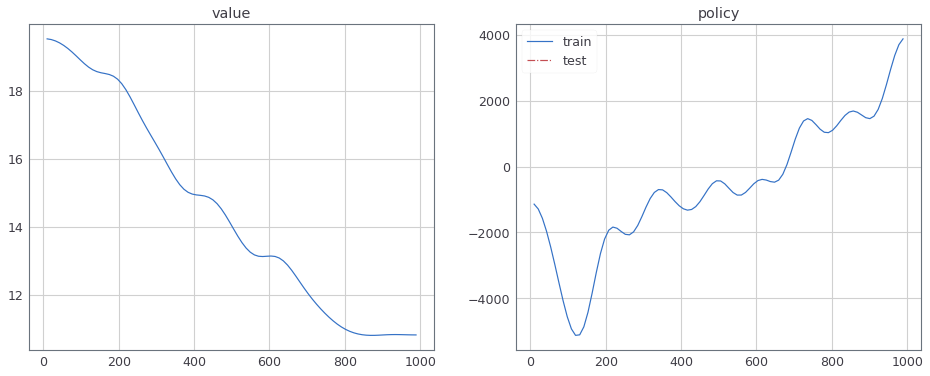

step:  1000 | value: 10.312933921813965 | policy 1737.69384765625


AssertionError: 

In [4]:
for epoch in range(n_epochs):
    for batch in tqdm(env.train_dataloader):
        loss = reinforce.update(batch)
        reinforce._step += 1
        if loss:
            plotter.log_losses(loss)
        if reinforce._step % plot_every == 0:
            clear_output(True)
            print('step', reinforce._step)
            plotter.plot_loss()
        if reinforce._step > 1000:
            assert False
            
        